In [7]:
import numpy as np
import pandas as pd
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from math import log10,sqrt

In [8]:
train_images=sorted(os.listdir('C:\\Users\\rohit\\Downloads\\chest_dataset'))

In [ ]:
test_images = []
test_folder = 'C:\\Users\\rohit\\Downloads\\chest_dataset\\'
test_image_filenames = os.listdir(test_folder)
for im in test_image_filenames:
    img_path = os.path.join(test_folder, im)
    try:
        img = image.load_img(img_path, target_size=(64, 64), color_mode='grayscale')
        img = image.img_to_array(img)
        img = img / 255.0
        test_images.append(img)
    except Exception as e:
        print(f"Error loading {im}: {e}")

xtest = np.array(test_images)
print("xtest shape:", xtest.shape)

xtest shape: (202, 64, 64, 1)


In [11]:
#Subplotting images
def plot_img(dataset):
  f,ax=plt.subplots(1,5)
  f.set_size_inches(40,20)
  for i in range(5,10):
    ax[i-5].imshow(dataset[i].reshape(64,64), cmap='gray')
  plt.show()

In [27]:
#Adding gaussian noise with 0.05 factor
def add_noise(image):
  row,col,ch=image.shape
  mean=0
  sigma=1
  gauss=np.random.normal(mean,sigma,(row,col,ch))
  gauss=gauss.reshape(row,col,ch)
  noisy=image+gauss*0.05
  return noisy

In [28]:
noised_df=[]
for img in train_df:
  noisy=add_noise(img)
  noised_df.append(noisy)

noised_df=np.array(noised_df)

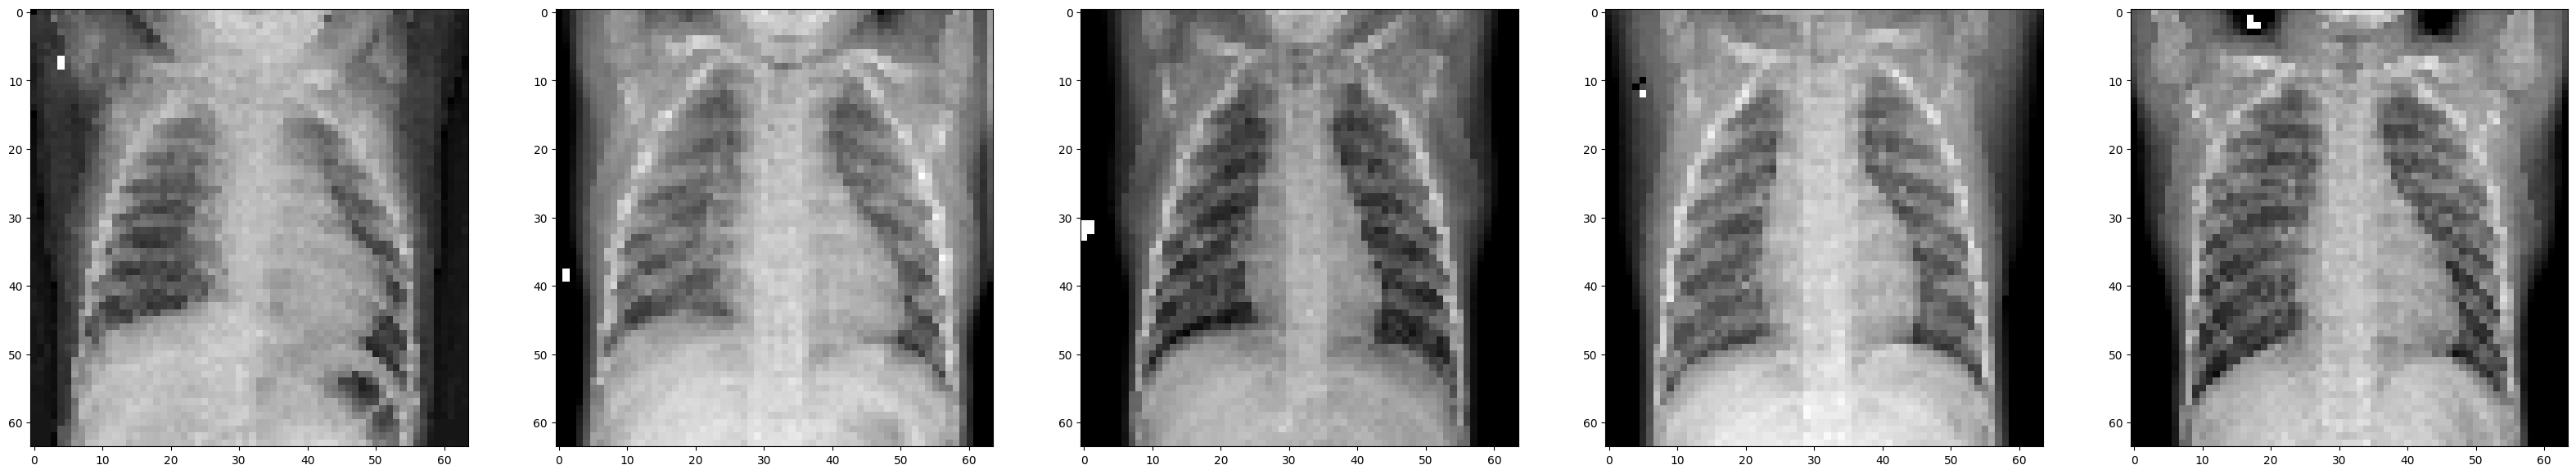

In [29]:
plot_img(train_df)

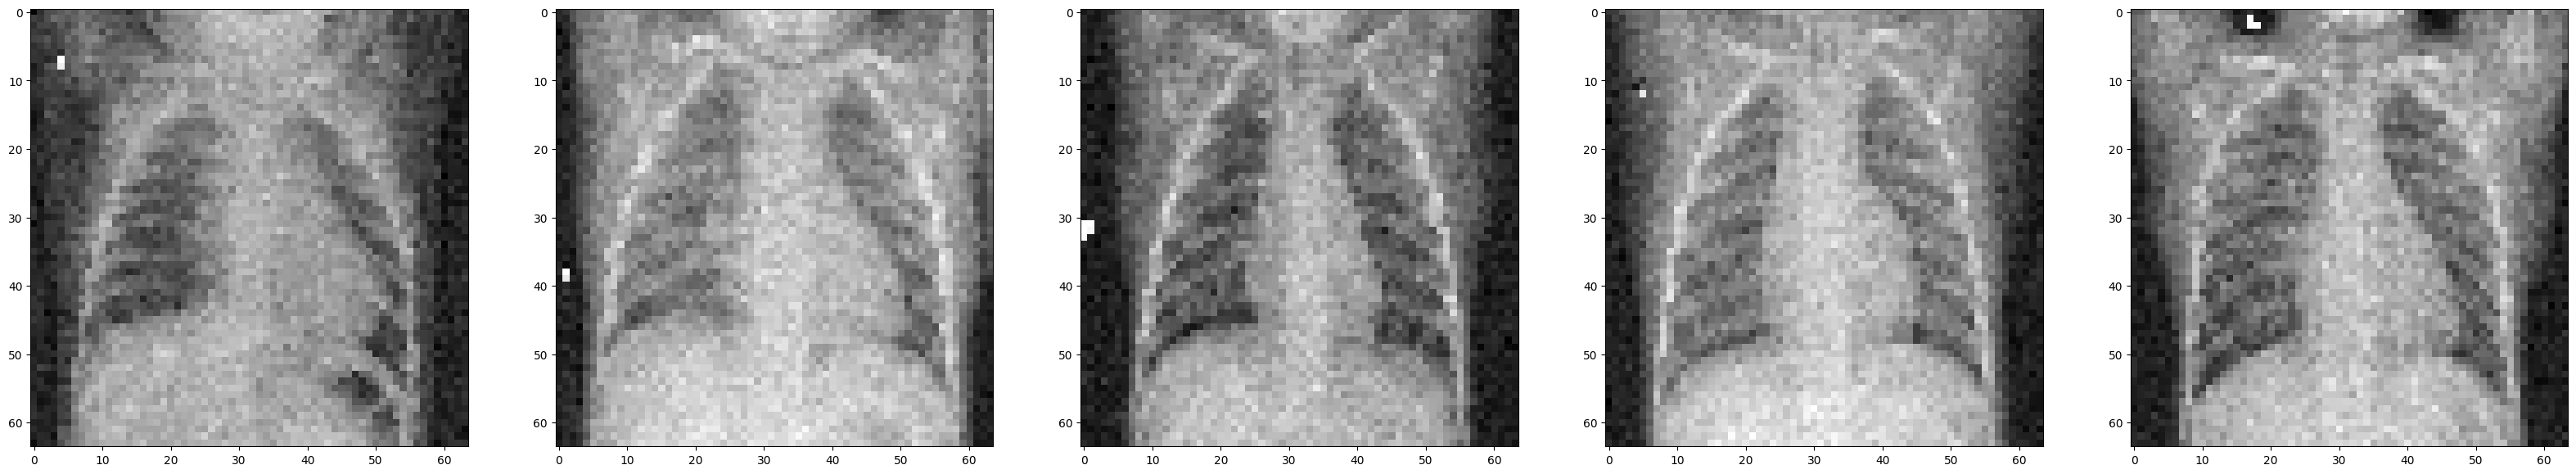

In [30]:
plot_img(noised_df)

In [31]:
xnoised=noised_df[:400]
xtest=noised_df[400:]

In [32]:
def autoencoder():
  input_img=Input(shape=(64,64,1),name='image_input')
  #enoder 
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
  x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
  x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
   
  #decoder
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
  x = UpSampling2D((2,2), name='upsample1')(x)
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv4')(x)
  x = UpSampling2D((2,2), name='upsample2')(x)
  x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
   
  #model
  autoencoder = Model(inputs=input_img, outputs=x)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
  return autoencoder

In [33]:
model= autoencoder()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsample1 (UpSampling2D)        │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsample2 (UpSampling2D)        │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv5 (Conv2D)                  │ (None, 64, 64, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,001 (437.50 KB)

 Trainable params: 112,001 (437.50 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    model.fit(xnoised, xnoised, epochs=18, batch_size=10, validation_data=(xtest, xtest), callbacks=[early_stopping])

Epoch 1/18
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6607
Epoch 2/18
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5799
Epoch 3/18
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5690
Epoch 4/18
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5644
Epoch 5/18
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5647
Epoch 6/18
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5617
Epoch 7/18
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5585
Epoch 8/18
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5619
Epoch 9/18
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5579
Epoch 10/18
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5583
Epoch 11/18
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5603
Epoch 12/18
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5581
Epoch 13/18
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5565
Epoch 14/18
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5547
Epoch 15/18
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5488
Epoc

In [35]:
xtrain= train_df[100:]

In [39]:
print("xtest shape:", xtrain.shape)
print("xtest[:5] shape:", xtrain[:5].shape)


xtest shape: (102, 64, 64, 1)
xtest[:5] shape: (5, 64, 64, 1)
